# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [2]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()}))) # could have been implemented using set()

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [30]:
import problem_unittests as tests

from collections import Counter

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement Function
    vocab = Counter(text)
    print('number of words in vocab: {}'.format(len(vocab)))
    vocab_to_int = {}
    int_to_vocab = {}
    
    for idx, word_count in enumerate(vocab.most_common()):
        word = word_count[0]
        vocab_to_int[word] = idx
        int_to_vocab[idx] = word
    
    
    # return tuple
    return (vocab_to_int, int_to_vocab)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

number of words in vocab: 71
Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [33]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    punctuation_dict = {'.': '<Period>', 
                        ',': '<Comma>', 
                        '\"':'<Quotation>',
                        ';':'<Semicolon>',
                        '!':'<Exclamation>',
                        '?':'QuestionMark',
                        '(': '<LeftParentheses>',
                        ')':'<RightParentheses>',
                        '-': '<Dash>',
                        '\n':'<Return>'}
        
    return punctuation_dict

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to look at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

number of words in vocab: 21388


# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

In [2]:
len(vocab_to_int.keys())

21388

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [4]:
from torch.utils.data import TensorDataset, DataLoader


def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    
    end = len(words)-1-sequence_length
    sequences = []
    targets = []
    for idx in range(end+1):
        sequences.append(words[idx:idx+sequence_length])
        targets.append(words[idx+sequence_length])
    
    X = torch.LongTensor(sequences)
    y = torch.LongTensor(targets)
    dataset = TensorDataset(X, y)
    # return a dataloader
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    return dataloader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own


### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [5]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[32, 33, 34, 35, 36],
        [28, 29, 30, 31, 32],
        [ 6,  7,  8,  9, 10],
        [16, 17, 18, 19, 20],
        [30, 31, 32, 33, 34],
        [23, 24, 25, 26, 27],
        [43, 44, 45, 46, 47],
        [11, 12, 13, 14, 15],
        [42, 43, 44, 45, 46],
        [27, 28, 29, 30, 31]])

torch.Size([10])
tensor([37, 33, 11, 21, 35, 28, 48, 16, 47, 32])


---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [6]:
import numpy as np
import torch.nn.functional as F

In [18]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        # TODO: Implement function
        
        # set class variables
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        # list of units in the hidden linear layers
        self.list_linear_layers = [int((3*hidden_dim)//4), int(hidden_dim//2), output_size]
        self.num_linear_layers = len(self.list_linear_layers)
        
        # define model layers
        self.embed = nn.Embedding(num_embeddings = vocab_size, 
                                  embedding_dim = embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim,
                            num_layers = n_layers, batch_first = True, 
                            dropout = dropout)
        #self.dropout = nn.Dropout(p = dropout)
        
        device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
        self.batch1 = nn.BatchNorm1d(num_features = hidden_dim)
        self.l1 = nn.Linear(hidden_dim, self.list_linear_layers[0])
        self.batch2 = nn.BatchNorm1d(num_features = self.list_linear_layers[0])
        self.l2 = nn.Linear(self.list_linear_layers[0], self.list_linear_layers[1])
        self.batch3 = nn.BatchNorm1d(num_features = self.list_linear_layers[1])
        self.l3 = nn.Linear(self.list_linear_layers[1], self.list_linear_layers[2])
        
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        # TODO: Implement function
        
        embedding = self.embed(nn_input)
        lstm_out, hidden_n = self.lstm(embedding, hidden)
        
        # reshape lstm_out
        ############## Some Thoughts ###################
        # I don't know why they are implementing the forward function in this 
        # complicated way that involves many more computations than necessary
        # We are only interested in applying out linear layers to the prediction at the end of each sequence in the batch
        # Here, lstm_out constists of lstm's prediction after each step in the sequence
        # We can therefore simply pickout the last prediction in lstm_out for 
        # each sequence in the batch as follows: lstm_out = lstm_out[:,-1]
        # instead what they do is first reshape lstm_out. This will still contain all 
        # the lstm predictions for each step in the sequence
        # they then pass this through the linear layer and then appropriately reshape the output and 
        # pick out the linear layer's predictions for the last step in each sequence
        # Their way of doing it involves unneccessarily running the linear layers on all the steps in each sequence
        # I don't know why they do it this way when the I checked that the final output will be the same as in my way
        # Therefore I will try to do it my way 
        
        out = lstm_out[:,-1]
        out = self.batch1(out)
        out = F.relu(self.l1(out))
        out = self.batch2(out)
        out = F.relu(self.l2(out))
        out = self.batch3(out)
        out = self.l3(out) # note that they apply torch.CrossEntropyLoss() later
                           # so we will NOT apply a log_softmax activation here

        # return one batch of output word scores and the hidden state
        return out, hidden_n
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        
        h_0 = torch.FloatTensor(np.zeros(shape = (self.n_layers, batch_size, self.hidden_dim)))
        
        c_0 = torch.FloatTensor(np.zeros(shape = (self.n_layers, batch_size, self.hidden_dim)))
                               
        if torch.cuda.is_available():
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()
        
        
        return (h_0, c_0)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [19]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    clip = 5 # gradient clipping
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    inp = inp.to(device)
    hidden = tuple([state.to(device) for state in hidden])
    target = target.to(device)
    
    # perform backpropagation and optimization
    optimizer.zero_grad()
    out, hidden_n = rnn(inp, hidden)
    loss = criterion(out.squeeze(), target)
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    
    # detach the hidden state before returning it
    hidden_n = tuple([state.detach().clone() for state in hidden_n])
    
    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), hidden_n

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [21]:
# Data params
# Sequence Length
sequence_length =  12 # of words in a sequence
# Batch Size
batch_size = 128

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [22]:
# Training parameters
# Number of Epochs
num_epochs = 200
# Learning Rate
learning_rate = 0.0005

# Model parameters
# Vocab size
vocab_size = 21388
# Output size
output_size = 21388
# Embedding Dimension
embedding_dim = 500
# Hidden Dimension
hidden_dim = 700
# Number of RNN Layers
n_layers = 3

# Show stats for every n number of batches
show_every_n_batches = 2500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [23]:
import time
start = time.time()

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 200 epoch(s)...
Epoch:    1/200   Loss: 4.67717149810791

Epoch:    1/200   Loss: 4.195708262348175

Epoch:    2/200   Loss: 3.9769602008622402

Epoch:    2/200   Loss: 3.8765646728515626

Epoch:    3/200   Loss: 3.7675681346266776

Epoch:    3/200   Loss: 3.7112695746421815

Epoch:    4/200   Loss: 3.6243039198598224

Epoch:    4/200   Loss: 3.5820354439735413

Epoch:    5/200   Loss: 3.5139211382367623

Epoch:    5/200   Loss: 3.495944203567505

Epoch:    6/200   Loss: 3.4161247306020504

Epoch:    6/200   Loss: 3.410018182849884

Epoch:    7/200   Loss: 3.3370823291997085

Epoch:    7/200   Loss: 3.336393078327179

Epoch:    8/200   Loss: 3.270149114868683

Epoch:    8/200   Loss: 3.2806066261291504

Epoch:    9/200   Loss: 3.2203075312266387

Epoch:    9/200   Loss: 3.2161255046844484

Epoch:   10/200   Loss: 3.168631746134627

Epoch:   10/200   Loss: 3.1706214447021486

Epoch:   11/200   Loss: 3.1216541647937746

Epoch:   11/200   Loss: 3.1267714310646055

Epoch:   12

Epoch:   95/200   Loss: 2.1507971916296893

Epoch:   95/200   Loss: 2.1766675395488737

Epoch:   96/200   Loss: 2.1525306400235906

Epoch:   96/200   Loss: 2.167193626689911

Epoch:   97/200   Loss: 2.1518882527984102

Epoch:   97/200   Loss: 2.160877665090561

Epoch:   98/200   Loss: 2.1406683835654645

Epoch:   98/200   Loss: 2.1563633590698243

Epoch:   99/200   Loss: 2.1343834664256653

Epoch:   99/200   Loss: 2.158589588689804

Epoch:  100/200   Loss: 2.136682107774543

Epoch:  100/200   Loss: 2.1573824622154234

Epoch:  101/200   Loss: 2.1368261695201562

Epoch:  101/200   Loss: 2.1459669232845306

Epoch:  102/200   Loss: 2.1270944958539797

Epoch:  102/200   Loss: 2.1469469093322755

Epoch:  103/200   Loss: 2.129871584126602

Epoch:  103/200   Loss: 2.1447149133205414

Epoch:  104/200   Loss: 2.1232542468013578

Epoch:  104/200   Loss: 2.13814312915802

Epoch:  105/200   Loss: 2.121679724023016

Epoch:  105/200   Loss: 2.1393669806957245

Epoch:  106/200   Loss: 2.11736015202242

Epoch:  189/200   Loss: 1.937627924489975

Epoch:  190/200   Loss: 1.9248094569652452

Epoch:  190/200   Loss: 1.9435951288700104

Epoch:  191/200   Loss: 1.9183417198561428

Epoch:  191/200   Loss: 1.9359006511211396

Epoch:  192/200   Loss: 1.9216118983759338

Epoch:  192/200   Loss: 1.9379297183513642

Epoch:  193/200   Loss: 1.917795626715436

Epoch:  193/200   Loss: 1.935529078578949

Epoch:  194/200   Loss: 1.9218241094502595

Epoch:  194/200   Loss: 1.9343900402545928

Epoch:  195/200   Loss: 1.9161186039274398

Epoch:  195/200   Loss: 1.9346061391353606

Epoch:  196/200   Loss: 1.9193765732980088

Epoch:  196/200   Loss: 1.92728627409935

Epoch:  197/200   Loss: 1.911254178573419

Epoch:  197/200   Loss: 1.9259911568164825

Epoch:  198/200   Loss: 1.9115061838372385

Epoch:  198/200   Loss: 1.9284448964118956

Epoch:  199/200   Loss: 1.9086286580170473

Epoch:  199/200   Loss: 1.9188419625759126

Epoch:  200/200   Loss: 1.9070059195490965

Epoch:  200/200   Loss: 1.929480670261

/home/prarit/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
end = time.time()
time_taken = end - start
print('time taken to train for {} epochs: {: .3f} sec'.format(num_epochs, time_taken))

time taken to train for 200 epochs:  33444.926 sec


In [26]:
hours = time_taken/3600
print('Hours taken to train for {} epochs: {: .2f} hrs'.format(num_epochs, hours))

Hours taken to train for 200 epochs:  9.29 hrs


### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** 

Following is the table of my experiments (top to bottom in increasing choronological order):

  | batch_size | learning_rate | sequence length |embedding_dim | hidden_dim | num_epochs | final loss | remarks |
  |:---|:---|:---|:---|:---|:---|:---|:---|
  | 128| 0.1|30|200|200|10|~5.77 | loss fluctuated around 5.7 for all epochs| 
  |128|0.1|12|200|200|10|~5.77| loss fluctutated around 5.7 for all epochs| 
  |128|0.1|12|500|200|10|~5.77| loss fluctuated around 5.7 for all epochs|
  |128|0.001|12|500|200|10|~4.28| training seems to be much better with a smaller learning rate|
  |128|0.005|12|500|200|10|~4.29| loss became worse after increasing the learning rate slightly|
  |128|0.003|12|500|200|10|~4.6| lr > 0.001 seems to be not good for our purposes |
  |128|0.0005|12|500|200|10|~4.21| This seems like a good lr|
  |128|0.0005|12|500|500|10|~4.05| Increasing hidden_dim seems to help|
  |128|0.0001|12|500|500|10|~4.06| decreasing lr below 0.0005 does not change things much|
  |128|0.0005|12|700|500|10|~4.02| increasing the embedding_dim beyond 500 doesn't help much|
  |128|0.0005|12|500|700|10|~3.98| not a significant improvment|
  |128|0.0005|12|500|700|30|~3.80| loss seems to have leveled out with very slow improvments|
  |128|0.0005|12|500|700|10|~3.15| Switched from Dropout to BatchNormalization between the fully connected linear layers of the model; This seems to be pretty good let's train this for many more epochs| 
  |128|0.0005|12|500|700|200|~1.92| loss decreased (from ~ 2.1 to ~ 1.9) regularly but quite slowly in the last 100 epochs |
  
  
 I decide to first train for a small number of epochs and compare the results across experiments with various different choices of hyperparameters to find a good set that best solves the problem. So I chose my initial num_epochs = 10.
 
 Also, I had read in [this](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) book that " as a rule of thumb embeddings typically have 10 to 300 dimensions, depending on the task and the vocabulary size", so I decided to choose the initial embedding dim to be 200.
 
 I also decided to initially try keeping the hidden dim. to be same as the embedding dim. My reason behind this was the expectation that this way the LSTM layers will probably learn to predict the embedding vector for the word expected to appear in the next step of the sequence. Thus I used hidden dim. = 200 in my first experiment. 
 
 Since the effect of words appearring too far in the past should be minimal, I decided to not keep my sequence length to be too big. I thus started with seq. length. = 30 in the first experiment. 
 
 I also chose the learning rate to be 0.1, just because it seemed a reasonable value (not too big, neither too small) to start experimenting. 
 
 However, during the first 10 epochs the loss fluctuated around ~5.77 without showing any appreciable progress in training. 
 
 I wordered if this is because the sequence is too long. There are ~ 5 words per line, so for a sequence of 30 words, we are depending upon the last 5 lines to predict the next word in the sequence. This seemed a little bit of an overkill to me, so I reduced the sequence length to 12 word which is about ~ 1.5 lines. . However, this didn't change things much. 
 
 Next, I tried increasing the embedding dim. to 500 which didn't help either. So, I tried to decrease the learning rate to 0.001. This gave an error of ~ 4.28 after 10 epochs, which was clearly an improvment. I also tried 0.003 and 0.005 for the learning rate but they didn't seem do better than 0.001. However, reducing the learning rate further to 0.0005 gave a loss of 4.21 after 10 epochs, which seemed like a mild improvment and therefore I decided to stick with a learning rate of 0.0005. 
 
 Next I played with the number of hidden dim. and embedding dim. and found that embedding dim = 500 and hidden dim. = 700 works well for me. So I decided to keep this. Upon training this for longer, I found that the loss leveled out pretty quickly, reaching only ~ 3.80 after 30 epochs (it was ~ 3.98 after the first 10 epochs).
 
 Note that in my model so far, I had used Dropout between the fully connected layer of my model. I chose the dropout prob. to be same as the one passed by the user during the initialization of the model. For my next experiment, I switched the Dropout layers with BatchNormalization layers sandwiched between the linear layers. This proved to be a _**gamechanger**_. The loss already decreased to ~ 3.15 after the first 10 epochs. I therefore decided to train this model for a longer time and trained it for about 200 epochs, to see how low can its loss get. At the end of training, the loss was ~ 1.92 which is significantly better than the expected benchmark for this project. However, notice that loss decreased (from ~ 2.1 to ~ 1.9) regularly but quite slowly in the last 100 epochs. So had I trained for only 100 epochs, I would have saved a lot more time (it took ~ 9.29 hrs to finally train the model for 200 epochs) without sacrificing too much in terms of the quality of my training. Lesson learned! :)

---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnn')

## PCA analysis of the space of embeddings

To further analyse the efficacy of our chosen value for embedding dimension, let apply PCA to it and compute the explained variance ratio along PCA dimension. The idea here is that if the space of embeddings has been chosen to be too large, then this will probably become apparent in a PCA analysis if the explained variance of various dimensions drops sharply after a certain number of pca components. The point at which such a sharp drop appears (if at all) will give us a better idea of a more appropriate value for embedding dimensions. On the other hand, if no such sharp drop appears, then we can safely assume, that our chosen value is probably fine for our purposes.  

In [47]:
from sklearn.decomposition import PCA

In [56]:
import matplotlib.pyplot as plt

In [43]:
word_embeddings = trained_rnn.embed.weight.detach().clone().cpu().numpy()

In [48]:
pca = PCA()
pca.fit(word_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_

In [54]:
cummulative_variance = np.cumsum(explained_variance_ratio)

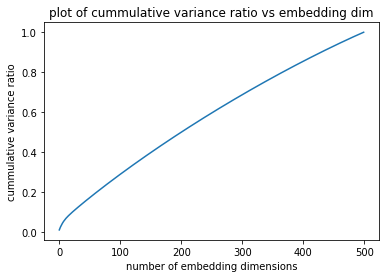

In [59]:
plt.plot(cummulative_variance)
plt.xlabel('number of embedding dimensions')
plt.ylabel('cummulative variance ratio')
plt.title('plot of cummulative variance ratio vs embedding dim')
plt.show()

We see that the cummulative explained variance increases steadily with the number of embedding dimensions with plateauing at any point.  Has it plateaued off at some point, it would have indicated that the number of embedding dimensions is much larger than required for the current task. The fact that is does not have a plateau therefore shows that the number of embedding dimensions chosen by us was quite appropriate.

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        if(train_on_gpu):
            current_seq = current_seq.cpu() # move to cpu
        # the generated word becomes the next "current sequence" and the cycle can continue
        if train_on_gpu:
            current_seq = current_seq.cpu()
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [36]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

jerry: which is like, y'know jumping from the inside, but the water was cold virtually... and if i hear it, i would eat it if you would have had said no one's ever seen that kind of effect around the top of a piece of *fruit* to save name.

kramer:(to mickey) hey, you watchin' oprah?

jerry: yeah, i know, but i know.

margaret: i mean someone knows what to do. i don't need to talk about it in your house if i had to.(george reluctantly laughs.)

carl: elaine, i can't believe the last time she came.

jerry: oh.

uncle leo: helloooo, will you ever start with me?

kramer: yeah, yeah...

olive: but you thought it was it? why'd you tell that guy?

kramer: he said i was gonna get a christmas card.

jerry: i don't have a washcloth though.

george:(thomassoulo helps him get up to leave) no, thank you.(moving to the other side of the board of hands in the air and the counter to five.

jerry: i know!

george: we just met.

[scene: at jerrys apartment]

jerry: so did you enjoy the dial?

elaine: i

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [37]:
# save script to a text file
f =  open("generated_script_1.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.